# Ascending vs. Descending Base Mean Gene Signature Selection
Andrew E. Davidson  
aedavids@ucsc.edu  
7/2/24

Copyright (c) 2020-2023, Regents of the University of California All rights reserved. https://polyformproject.org/licenses/noncommercial/1.0.0

ref: extraCellularRNA/deconvolutionAnalysis/jupyterNotebooks/hyperParameterTunning/hyperparameterTunningResults6.ipynb

**Abstract**  
- best10CuratedDegree1_ce467ff has best results. 
- potential bug: sorted base mean in ascending order. this picks potentiall weak signals
- best10CuratedDegree1 is sorted in desecnding order.
- create box plots and histograms of base means to decide if best10CuratedDegree1_ce467ff is valid

**Results**  
<span style="color:red;background-color:yellow">TODO</span>  

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import logging

import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import sys

/data/tmp/ipykernel_3678773/2184894980.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
root = "/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category"
notebookName = ipynbname.name()
outDir = f'{root}/hyperParameter/{notebookName}.out'
print( f'output dir: \n{outDir}' )
os.makedirs(outDir, exist_ok=True)

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

output dir: 
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out

imgOut :
/private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out/img


In [3]:
#loglevel = "INFO"
loglevel = "WARN"
#logFMT = "%(asctime)s %(levelname)s [thr:%(threadName)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logFMT = "%(asctime)s %(levelname)s %(name)s %(funcName)s() line:%(lineno)s] [%(message)s]"
logging.basicConfig(format=logFMT, level=loglevel)    
logger = logging.getLogger(notebookName)

In [4]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = os.environ['PYTHONPATH']
print("ORIG_PYTHONPATH: {}\n".format(PYTHONPATH))

gitRepoRoot = !git rev-parse --show-toplevel
gitRepoRoot = gitRepoRoot[0]

#
# add deconvolutionAnalysis modules
#
deconvolutionModules = f'{gitRepoRoot}/deconvolutionAnalysis/python'
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = PYTHONPATH + f':{deconvolutionModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(deconvolutionModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

#
# add intraExtraRNA_POC modules
#
intraExtraRNA_POCModules = f'{gitRepoRoot}/intraExtraRNA_POC/python/src'
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
#print("PYTHONPATH: {}\n".format(PYTHONPATH))

sys.path.append( str(intraExtraRNA_POCModules) )
#print("\nsys.path:\n{}\n".format(sys.path))

ORIG_PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src

deconvolutionModules: /private/home/aedavids/extraCellularRNA/deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/python/src



In [5]:
from analysis.hyperParameterTunningMetrics import metricsRunner, elifeCols, lungCols
from analysis.hyperParameterTunningMetrics import findSummaryMetricsCols

# from analysis.hyperParameterTunningMetrics import symetricRowSort
# from analysis.utilities import findAllCategories, findAllGenes
# from analysis.utilities import findIntersectionsWithDegree
# from analysis.utilities import loadDictionary
from analysis.utilities import findSignatureGenesForPipelineStage

from bme263DataVis.utilities import MatPlotLibUtilities

from pipeline.dataFactory.utilities import urlify

# Hyperparmeter Tunning Metrics

In [6]:
def evaluateDeconvolution(
    root: str,
    outDir: str,    
    resultsDirs : list[str],
    outFilePrefix : str,
    metric : str,
    #stageName : str, #  stageName is part of the outputfile prefix
    threshold : float,
    verbose : bool = False,
    ) -> tuple[pd.DataFrame, pd.DataFrame] :
    '''
    TODO: this was cut-n-paste from hyperparameterTunningResults6.ipynb

    display(df.loc[:, findSummaryMetricsCols(metric) + elifeCols  ] )
    
    returns:
        df : 
            returns a row for each run in resultsDirs 
            The row contains the "metric" for each class + summary statistic

        bellowThresholdDF:
            example:
                    stage	        category	               value
                id			
                0	best10GTEx_TCGA	ACC	                        True
                2	best10GTEx_TCGA	Adipose_Visceral_Omentum	True
                5	best10GTEx_TCGA	Artery_Coronary	            True
                7	best10GTEx_TCGA	BLCA	                    True
                8	best10GTEx_TCGA	BRCA	                    True
            
    '''

    retDF, retBellowThresholdDF = metricsRunner(root, outDir, outFilePrefix, resultsDirs, 
                           metric=metric, threshold=threshold, verbose=verbose)

    display( retDF.loc[:, findSummaryMetricsCols(metric) + elifeCols  ] )

    # print(f'\n{stageName} classs < {threshold} {metric}')
    # selectRowsBellow = retBellowThresholdDF.loc[:, "stage"] == stageName
    
    # display( retBellowThresholdDF.loc[selectRowsBellow, 'category'] )

    return (retDF, retBellowThresholdDF)

In [7]:
def evaluateBest10CuratedDegree1(
        threshold : float = 0.7,
        metric : str = 'sensitivity',
        verbose : bool = False):
    '''
    TODO: this was cut-n-paste from hyperparameterTunningResults6.ipynb
    '''
    bestBes10ResultsDirs = [    
        "best10CuratedDegree1_ce467ff",        
        # "best10CuratedDegree1Ascending", # Ascending performance should match ce467ff
        "best10CuratedDegree1",
    ]
    
    print(f'metric : {metric} threshold: {threshold}')
    #stageName = "AEDWIP"
    outFilePrefix =  "best10CuratedDegree1Runs" 
    best10DF, bestBellowThresholdDF = evaluateDeconvolution(
                                            root=root,
                                            outDir=outDir,
                                            resultsDirs=bestBes10ResultsDirs, 
                                            outFilePrefix=outFilePrefix,
                                            metric=metric,
                                            #stageName=stageName,
                                            threshold=threshold,
                                            verbose=verbose,
                                            )
    
    return(best10DF, bestBellowThresholdDF)

In [8]:
evaluateBest10CuratedDegree1SpecificityThreshold = 0.96
evaluateBest10CuratedDegree1SpecificityMetric = "specificity"

t = evaluateBest10CuratedDegree1(threshold=evaluateBest10CuratedDegree1SpecificityThreshold, 
                                 metric=evaluateBest10CuratedDegree1SpecificityMetric, verbose=False)

evalBest10CuratedDegree1SpecificityDF, evalBest10CuratedDegree1SpecificityBellowThresholdDF = t

metric : specificity threshold: 0.96

saving : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out/best10CuratedDegree1Runs.specificity.0.96.csv

saving : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out/best10CuratedDegree1Runs.specificity.bellow.0.96.csv


id,mean_specificity,std_specificity,median_specificity,numGenes,numTypes,numDegree1,numAboveThreshold,percentAboveThreshold,LUAD,LUSC,COAD,READ,ESCA,LIHC,STAD,Whole_Blood
best10CuratedDegree1_ce467ff,0.997855,0.002922,0.999,716,83,83,83,1.0,0.998,0.995,0.995,0.996,0.999,1.000,0.999,0.999
best10CuratedDegree1,0.997542,0.003030,0.998,716,83,83,83,1.0,1.000,0.994,0.993,0.991,0.998,0.999,1.000,1.000


In [9]:
evaluateBest10CuratedDegree1SensitivityMetric = 'sensitivity'
evaluateBest10CuratedDegree1SensitivityThreshold = 0.90

t =  evaluateBest10CuratedDegree1(
        threshold=evaluateBest10CuratedDegree1SensitivityThreshold,
        metric=evaluateBest10CuratedDegree1SensitivityMetric)

evalBest10CuratedDegree1SensitivityDF, evalBest10CuratedDegree1SensitivityBellowThresholdDF  = t

metric : sensitivity threshold: 0.9

saving : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out/best10CuratedDegree1Runs.sensitivity.0.9.csv

saving : /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out/best10CuratedDegree1Runs.sensitivity.bellow.0.9.csv


id,mean_sensitivity,std_sensitivity,median_sensitivity,numGenes,numTypes,numDegree1,numAboveThreshold,percentAboveThreshold,LUAD,LUSC,COAD,READ,ESCA,LIHC,STAD,Whole_Blood
best10CuratedDegree1_ce467ff,0.808831,0.202235,0.871,716,83,83,36,0.433735,0.841,0.691,0.652,0.607,0.369,0.874,0.409,1.000
best10CuratedDegree1,0.786482,0.206089,0.833,716,83,83,30,0.361446,0.485,0.595,0.627,0.679,0.396,0.906,0.271,0.987


# Ascending vs. Descending Box Plots

In [10]:
def getCategories( 
        df : pd.DataFrame,
        metric : str = 'sensitivity'
    ) -> list[str] :
    '''
    removes metric releated columns

    returns tissue type columns
    
    example df: evalBest10CuratedDegree1SensitivityDF
    '''
    
    retList = list(evalBest10CuratedDegree1SensitivityDF)
    
    for c in findSummaryMetricsCols( metric):
        retList.remove( c )

    return retList

In [11]:
def loadBaseMeans(
        df : pd.DataFrame,
        runName : str,
        metric : str = 'sensitivity',
        ascendingDecendingHack=False):
    '''
    TODO
    '''
    retList = []
    categoryList = getCategories(df, metric)
    for c in categoryList:
        baseMeansList = findSignatureGenesForPipelineStage(category=c, 
                                                           pipelineStageName=runName, 
                                                           colName="baseMean",
                                                          ascendingDecendingHack=ascendingDecendingHack)
        retList = retList + baseMeansList

    return retList
    

In [12]:
ascendingRunName = "best10CuratedDegree1_ce467ff"

# There should not be any duplicates.
# use set to make sure we get unique values. 
asendingBaseMeans = list( set( 
                            loadBaseMeans( evalBest10CuratedDegree1SensitivityDF, ascendingRunName, "sensitivity" ) 
                             )
                        )

assert len(asendingBaseMeans) == 716 , f"ERROR len(asendingBaseMeans) = {len(asendingBaseMeans)}"

In [13]:
descendingRunName = "best10CuratedDegree1"

# There should not be any duplicates.
# use set to make sure we get unique values. 
desendingBaseMeans = list(
                            set( loadBaseMeans( evalBest10CuratedDegree1SensitivityDF, 
                                        descendingRunName, 
                                        "sensitivity", ascendingDecendingHack=True ) 
                               )
                            )

assert len(desendingBaseMeans) == 716 , f"ERROR len(desendingBaseMeans) = {len(desendingBaseMeans)}"

In [14]:
def klBoxPlot(values :list[float], 
            labels: list[str], 
            title : str,
              panel : plt.axes, 
            # w : int = 4,
            # h :  int = 4,
            showmeans=True,
             vert=True,
              showfliers=True, 
              #meanline=False
             #) -> tuple[plt.figure, list[plt.axes], dict]:
             ) -> dict :
    '''
    TODO
    https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html

    # returns a tuple with elements:
    #     figure, 
    #     list of panels,
    #     dictionary returned by matplotlib.axes.Axes.boxplot. All the values are lists of matplotlib.lines.Line2D


    returns:
        dictionary returned by matplotlib.axes.Axes.boxplot. All the values are lists of matplotlib.lines.Line2D

    TODO: this was cut-n-paste from extraCellularRNA/terra/GTExTCGA_Release/jupyterNotebooks/boxPlots.ipynb
        
    '''
    # w = 12
    # h = 3
    #fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(w, h), ) #sharey=True
    panel.set_title( title )
    #fig.suptitle( "sub title" )
    # vert=False # display box blot with label along the y axis
    # vert=True 
    boxPlotResultsDict = panel.boxplot(values, labels=labels, 
                             showmeans=showmeans, 
                             #meanline=meanline,
                             vert=vert,
                            showfliers=showfliers,
                            )

    panel.set_xticks(panel.get_xticks(), panel.get_xticklabels(), rotation=45, ha='right')


    #return (fig, axs, boxPlotResultsDict)
    return boxPlotResultsDict

saved image to /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/hyperParameter/ascending-vs.-DescendingBaseMeanGeneSignatureSelection.out/img/baseMean-best10CuratedDegree1-vs-best10CuratedDegree1_ce467ff.png


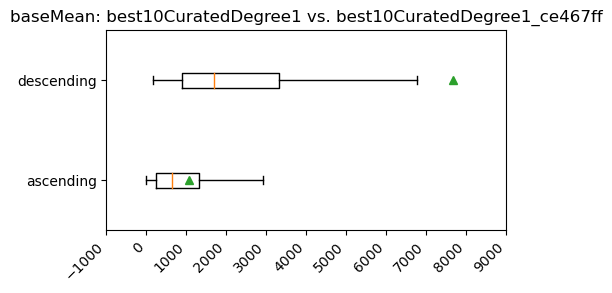

In [19]:
def createBoxPlot(df):
    pageWidthInInches = 4
    pageHeightInInches = 2
    boxPlotFig =  plt.figure( figsize=( pageWidthInInches, pageHeightInInches ) )
    mplu = MatPlotLibUtilities()
    boxPlotPanel = mplu.createPanelSameSizeAsFig(boxPlotFig)
    
    title = f'baseMean: {descendingRunName} vs. {ascendingRunName}'
    # recorderLabels = [ 'GTEX-1117F-0526-SM-5EGHJ', 'GTEX-1117F-0226-SM-5GZZ7', 'GTEX-1117F-0726-SM-5GIEN']
    # reoderTestValues = testValues.loc[:, recorderLabels]
    # testFig, testPanels, testBoxPlotDict = klBoxPlot(reoderTestValues, recorderLabels, testTitle, showfliers=True)

    #print(baseMeansDF.shape)
    # display(baseMeansDF.head()) 
    
    labels = baseMeansDF.columns
    testBoxPlotDict = klBoxPlot(baseMeansDF, labels, title, boxPlotPanel, showfliers=False, vert=False)
    
    imgFilePath = f'{imgOut}/{urlify(title)}.png'
    boxPlotFig.savefig(imgFilePath, dpi=300, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

baseMeansDF = pd.DataFrame( {'ascending' : asendingBaseMeans,
                            'descending' : desendingBaseMeans, })
    
createBoxPlot(baseMeansDF)

(array([279., 138., 118.,  71.,  50.,  14.,  18.,   5.,   8.,   1.,   2.,
          1.,   2.,   0.,   2.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.86944625e+00, 4.29877100e+02, 8.57884753e+02, 1.28589241e+03,
        1.71390006e+03, 2.14190771e+03, 2.56991537e+03, 2.99792302e+03,
        3.42593068e+03, 3.85393833e+03, 4.28194598e+03, 4.70995364e+03,
        5.13796129e+03, 5.56596894e+03, 5.99397660e+03, 6.42198425e+03,
        6.84999190e+03, 7.2779

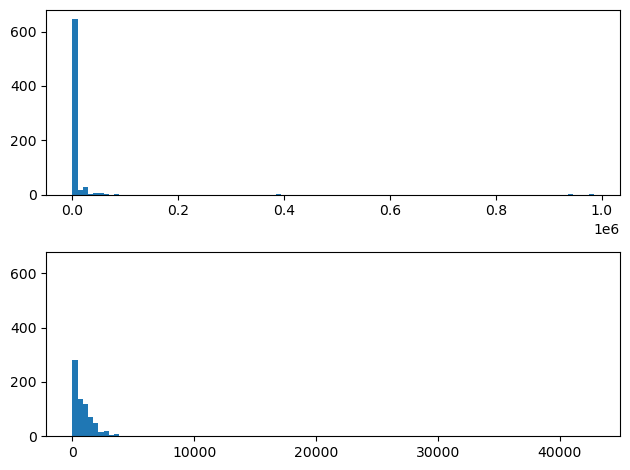

In [23]:
fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True)
nBins = 100 #50# 25
axs[0].hist(baseMeansDF.loc[:, "descending"], bins=nBins)
axs[1].hist(baseMeansDF.loc[:, "ascending"], bins=nBins)